# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_CIFAR10_data(num_training=8000, num_validation=1000, num_test=1000,
                     num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (8000, 3073)
Train labels shape:  (8000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [56]:
# Debug cell
print("max val in X_dev: ", np.max(X_dev))
print("max val in X_train: ", np.max(X_train))
print("max val in X_val: ", np.max(X_val))

max val in X_dev:  0.0
max val in X_train:  155.99275
max val in X_val:  155.965625


## Softmax Classifier

Your code for this section will all be written inside
**cs231n/classifiers/softmax.py**.


In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
#loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
loss_v, grad_v = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss_v)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.317690
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*

In softmax-loss, argument of -log(x) is probability of corectness of given class score, so if we use random weight to calculate loss function it's close to probablity of correst guess. If there is 10 diffrent classes, probability of correct class is 0.1, so the value of loss function should be around -log(0.1)


In [58]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.451344 analytic: -0.451338, relative error: 6.152925e-06
numerical: 4.220005 analytic: 4.220008, relative error: 2.745286e-07
numerical: 9.675121 analytic: 9.675123, relative error: 7.579969e-08
numerical: 4.578654 analytic: 4.578657, relative error: 3.418018e-07
numerical: 4.391611 analytic: 4.391615, relative error: 3.868652e-07
numerical: 9.350282 analytic: 9.350283, relative error: 5.086422e-08
numerical: -4.670966 analytic: -4.670961, relative error: 4.952342e-07
numerical: -0.817116 analytic: -0.817112, relative error: 2.090153e-06
numerical: 1.073597 analytic: 1.073600, relative error: 1.249371e-06
numerical: 3.214193 analytic: 3.214195, relative error: 3.136288e-07
numerical: 4.238526 analytic: 4.238528, relative error: 2.409853e-07
numerical: -31.059771 analytic: -31.059768, relative error: 4.185854e-08
numerical: -3.982386 analytic: -3.982382, relative error: 5.770855e-07
numerical: 0.851737 analytic: 0.851741, relative error: 2.414749e-06
numerical: 7.572562 an

In [7]:
# Now that we have a naive implementation of the softmax loss function and its
# gradient, implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version
# should be much faster.

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.317690e+00 computed in 0.103778s
vectorized loss: 2.317690e+00 computed in 0.103097s


Loss difference: 0.000000
Gradient difference: 0.000000


In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

def calculate_accuracy(y_pred, y):
    """Calculates accuracy xd"""
    return np.mean(y_pred==y)

num_iters = 1200  # number of iteration over batches

tic = time.time()

for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=num_iters, batch_size=128, verbose=True)
        
        # calculate training accuracy
        accuracy_train = calculate_accuracy(softmax.predict(X_train), y_train)

        # calculate validation accuracy
        accuracy_val = calculate_accuracy(softmax.predict(X_val), y_val)

        # keep results in dictionery for later analysis
        results[(lr, rs)] = (accuracy_train, accuracy_val)
        
        # check if results are better than previous
        if accuracy_val > best_val:
            best_val = accuracy_val
            best_softmax = softmax
            
toc = time.time()
print('Done! That took %fs' % (toc - tic))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Training with: learning rate = 1e-07, reg = 25000.0
iteration 0 / 1200: loss 394.456549
iteration 100 / 1200: loss 237.898913


iteration 200 / 1200: loss 144.671624


iteration 300 / 1200: loss 88.205298


iteration 400 / 1200: loss 54.215023


iteration 500 / 1200: loss 33.540374


iteration 600 / 1200: loss 21.100112


iteration 700 / 1200: loss 13.478729


iteration 800 / 1200: loss 8.916159


iteration 900 / 1200: loss 6.200572


iteration 1000 / 1200: loss 4.563955


iteration 1100 / 1200: loss 3.591516


Training with: learning rate = 1e-07, reg = 50000.0


iteration 0 / 1200: loss 775.882028
iteration 100 / 1200: loss 285.542608


iteration 200 / 1200: loss 105.565740


iteration 300 / 1200: loss 40.033735


iteration 400 / 1200: loss 16.014338


iteration 500 / 1200: loss 7.110242


iteration 600 / 1200: loss 3.947030


iteration 700 / 1200: loss 2.797147


iteration 800 / 1200: loss 2.298590


iteration 900 / 1200: loss 2.224176


iteration 1000 / 1200: loss 2.143482


iteration 1100 / 1200: loss 2.085552


Training with: learning rate = 5e-07, reg = 25000.0


iteration 0 / 1200: loss 387.366231
iteration 100 / 1200: loss 32.759123


iteration 200 / 1200: loss 4.593227


iteration 300 / 1200: loss 2.260902


iteration 400 / 1200: loss 2.006958


iteration 500 / 1200: loss 2.122778


iteration 600 / 1200: loss 1.987659


iteration 700 / 1200: loss 2.085853


iteration 800 / 1200: loss 1.941125


iteration 900 / 1200: loss 2.033689


iteration 1000 / 1200: loss 2.031214


iteration 1100 / 1200: loss 2.000171


Training with: learning rate = 5e-07, reg = 50000.0


iteration 0 / 1200: loss 773.040794
iteration 100 / 1200: loss 6.808223


iteration 200 / 1200: loss 2.134349


iteration 300 / 1200: loss 2.059717


iteration 400 / 1200: loss 2.117394


iteration 500 / 1200: loss 2.113312


iteration 600 / 1200: loss 2.117468


iteration 700 / 1200: loss 2.165743


iteration 800 / 1200: loss 2.064738


iteration 900 / 1200: loss 2.004241


iteration 1000 / 1200: loss 2.090206


iteration 1100 / 1200: loss 2.141118


Done! That took 143.835775s


lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.359375 val accuracy: 0.353000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.341875 val accuracy: 0.324000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.362875 val accuracy: 0.347000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.325625 val accuracy: 0.314000
best validation accuracy achieved during cross-validation: 0.353000


In [11]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.345000


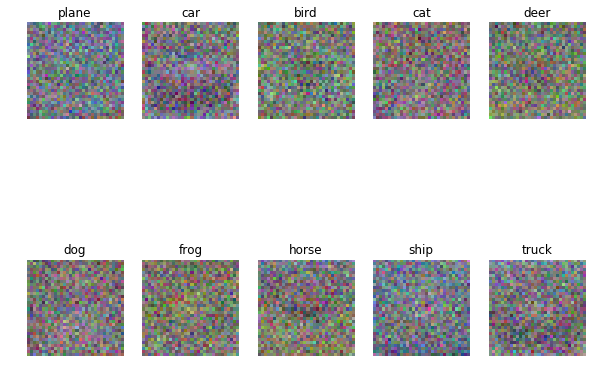

In [12]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])